In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Split
from sklearn.model_selection import train_test_split

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

df = pd.read_csv("data/train.csv")
df.head()

,user_id,item_id,rating,timestamp
0,0,7314,5.0,1353612262000
1,0,15493,5.0,1370653034000
2,0,18817,4.0,1373668644000
3,0,18251,4.0,1373669469000
4,0,16199,1.0,1375136041000


In [3]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 2543146
Total Columns: 4


In [4]:
# Taking subset of the dataset
df = df.iloc[:5000,0:]

In [5]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 5000
Total Columns: 4


In [6]:
print("Total number of ratings :",df.rating.nunique())
print("Total number of users   :", df.user_id.nunique())
print("Total number of products  :", df.item_id.nunique())

Total number of ratings : 5
Total number of users   : 1610
Total number of products  : 2489


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    5000 non-null   int64  
 1   item_id    5000 non-null   int64  
 2   rating     5000 non-null   float64
 3   timestamp  5000 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 156.4 KB


In [8]:
df.isnull().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

In [9]:
# Check missing value
df.isnull().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

In [10]:
# Check Duplicate data
df[df.duplicated()].any()


user_id      False
item_id      False
rating       False
timestamp    False
dtype: bool

In [11]:
# rating describe summary 
df.describe()['rating']

count    5000.000000
mean        4.068400
std         1.323659
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

In [12]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [13]:
# Average rating of products
ratings = pd.DataFrame(df.groupby('item_id')['rating'].mean())
ratings['ratings_count'] = pd.DataFrame(df.groupby('item_id')['rating'].count())
ratings['ratings_average'] = pd.DataFrame(df.groupby('item_id')['rating'].mean())
ratings.head(10)

,rating,ratings_count,ratings_average
item_id,,,
64,5.0,1,5.0
104,5.0,1,5.0
224,1.0,1,1.0
314,3.0,1,3.0
448,4.0,1,4.0
608,5.0,1,5.0
776,5.0,1,5.0
970,5.0,1,5.0
1224,4.0,1,4.0


<AxesSubplot:>

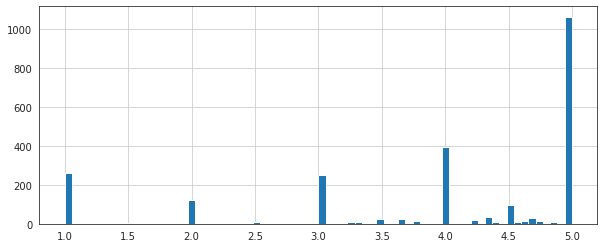

In [14]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

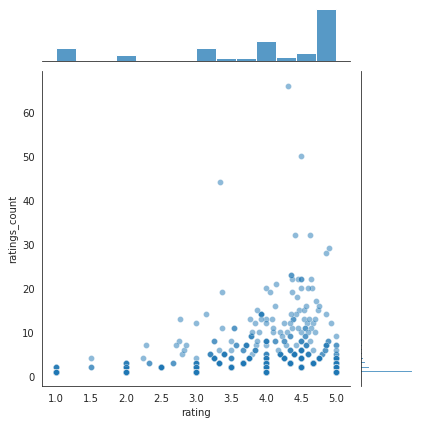

In [15]:
sns.jointplot(x='rating',y='ratings_count',data=ratings,alpha=0.5)

<AxesSubplot:xlabel='item_id'>

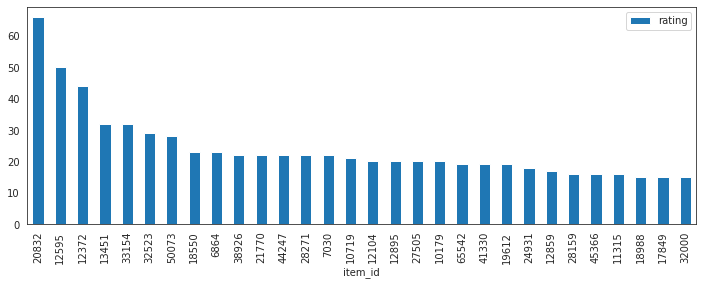

In [16]:
# Most top 30 products
popular_products = pd.DataFrame(df.groupby('item_id')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

## Popular Based Method


### Dodaj item_id do metadanych

In [17]:
import json
train_df = pd.read_csv("data/train.csv")
meta_df = pd.read_csv("data/item_metadata_filtered.csv")
with open("data/id_mappings.json") as f:
    id_map = json.load(f)

asin_to_id = {asin: int(item_id) for asin, item_id in id_map["item_mapping"].items()}
item_mapping_df = pd.DataFrame(list(asin_to_id.items()), columns=["parent_asin", "item_id"])
meta_df = pd.merge(meta_df, item_mapping_df, on="parent_asin", how="left")

### Wylicz WR score

Poniżej wyliczam z dosłownie wszystkich przedmiotów średnią, może być tu problem, bo być może trzeba to robić z tylko ocenami danego przedmiotu

In [18]:
vote_counts = ratings[ratings['ratings_count'].notnull()]['ratings_count'].astype('int')
vote_averages = ratings[ratings['ratings_average'].notnull()]['ratings_average'].astype('int')
C = vote_averages.mean()
print("Average rating of product across the whole dataset is",C)
m = vote_counts.quantile(0.95)
print(vote_counts)
print(m)

Average rating of product across the whole dataset is 3.84451586982724
item_id
64       1
104      1
224      1
314      1
448      1
        ..
77632    1
77642    1
77678    1
77821    1
77825    1
Name: ratings_count, Length: 2489, dtype: int64
6.0


In [19]:
# Compute global variables once
C = meta_df['average_rating'].mean()
m = meta_df['rating_number'].quantile(0.95)

# Define the function
def weighted_rating(x):
    v = x['rating_number']
    R = x['average_rating']
    return (v / (v + m)) * R + (m / (v + m)) * C

    # return (v / (v + m) * R) + (m / (m + v) * C)

# Apply to the dataframe
meta_df['wr'] = meta_df.apply(weighted_rating, axis=1)


In [20]:
df = pd.read_csv("data/train.csv")
item_metadata_df = pd.read_csv("data/item_metadata.csv")
other = pd.read_json("data/id_mappings.json")

# Extract the dictionary inside "user_mapping"
user_mapping = other["user_mapping"]
item_mapping = other["item_mapping"]

# Convert to DataFrame
user_mapping_df = pd.DataFrame(list(user_mapping.items()), columns=["user_id", "user_index"])
item_mapping_df = pd.DataFrame(list(item_mapping.items()), columns=["item_str_code", "item_id"])

item_metadata_df["item_id"] = item_metadata_df["parent_asin"].map(item_mapping)
item_merge_df = pd.merge(item_metadata_df, item_mapping_df, how="left", left_on="parent_asin", right_on="item_str_code")
item_merge_df["item_id"] = item_merge_df["item_id_x"]



item_merge_df["item_id"] = item_merge_df["item_id"].astype(float)
item_merge_df = item_merge_df.drop('item_id_x', axis=1)
item_merge_df = item_merge_df.drop('item_id_y', axis=1)
item_merge_df = item_merge_df.drop('item_str_code', axis=1)


result = pd.merge(df, item_merge_df, how="left", left_on="item_id", right_on="item_id")
result

,user_id,item_id,rating,timestamp,parent_asin,main_category,title,average_rating,rating_number,price,store,features,description,images,categories,image_count,has_images,image_urls,category
0,0,7314,5.0,1353612262000,B006CQ8TC2,Appstore for Android,Turkey Season,3.5,304.0,0.99,"Gibbed Games, LLC","['Hunt and slay deviant turkeys, then go back ...",['Gobble gobble gobble! Turkeys are running am...,"{'hi_res': array([None, None, None, None, None...",[],6,True,['https://m.media-amazon.com/images/I/71oAt4H2...,Software
1,0,15493,5.0,1370653034000,B00B7S5FDG,Appstore for Android,Another Monster at the End of This Book...Star...,4.3,460.0,3.99,Sesame Workshop,['Bursting with innovative activities woven ri...,"[""Available for Kindle Fire tablets AND Fire T...","{'hi_res': array([None, None, None, None, None...",[],12,True,['https://m.media-amazon.com/images/I/B1dGfKbS...,Software
2,0,18817,4.0,1373668644000,B00DRPVE3M,Appstore for Android,UNO ™ & Friends - The Classic Card Game Goes S...,3.9,11842.0,None,Gameloft,['Create games and invite your friends to play...,"['UNO™ & Friends: Fast Fun for Everyone!UNO™, ...","{'hi_res': array([None, None, None, None, None...",[],6,True,['https://m.media-amazon.com/images/I/A1dc9cyK...,Software
3,0,18251,4.0,1373669469000,B00D948SS0,Appstore for Android,World's Biggest Wordsearch - Your daily free w...,3.8,8290.0,0.0,Supersonic Software Ltd,"['5,000 words to find' '361 puzzles based on a...","[""Find thousands of words in the biggest and b...","{'hi_res': array([None, None, None, None, None...",[],6,True,['https://m.media-amazon.com/images/I/A1cI1uy6...,Software
4,0,16199,1.0,1375136041000,B00BQPEIT2,Appstore for Android,Temple Run: Oz,4.0,1043.0,None,Disney,['Stunning environments inspired by the film –...,['The most thrilling running experience now co...,"{'hi_res': array([None, None, None, None, None...",[],6,True,['https://m.media-amazon.com/images/I/91BmBng4...,Software
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543141,868216,15203,5.0,1397341480000,B00B1TGUMG,Software,Microsoft Office Home and Student 2013 (1PC/1U...,4.3,1759.0,None,Microsoft,['NOTE: Windows XP and Vista NOT supported. Th...,['Product Description'\n 'Office Home & Studen...,{'hi_res': array(['https://m.media-amazon.com/...,['Software' 'Microsoft' 'All Microsoft'],6,True,['https://m.media-amazon.com/images/I/61vi4XLD...,Software
2543142,868216,51839,5.0,1500036628141,B06XS4YRWX,Software,"NTI Echo 3, Make an exact copy of a HDD or SSD...",3.5,17.0,None,Nti,"['Versatile: One-to-One Cloning, Dynamic Resiz...","['NTI Echo'\n ""is the perfect solution for all...","{'hi_res': array([None, None, None, None, None...",['Software' 'Utilities' 'Backup'],14,True,['https://m.media-amazon.com/images/I/81FlCZVs...,Software
2543143,868217,14052,4.0,1464923235000,B00AB7HESI,Appstore for Android,Scribblenauts Remix,3.8,5520.0,0.99,Warner Bros,['CLASSIC GAMEPLAY - 50 levels to play!'\n 'PL...,['THINK IT! CREATE IT! SOLVE IT! The award-win...,"{'hi_res': array([None, None, None, None, None...",[],6,True,['https://m.media-amazon.com/images/I/81bAX50X...,Software
2543144,868217,40099,4.0,1465146950000,B014RGFC0K,Appstore for Android,Smashy Road: Wanted,3.6,7541.0,0.0,Bearbit Studios B.V.,['90 unlockable vehicles!!'\n 'Random generate...,['You are WANTED! Take your driving to new hei...,"{'hi_res': array([None, None, None, None, None...",[],9,True,['https://m.media-amazon.com/images/I/71TPOiUY...,Software


In [46]:
def compute_weighted_rating(df, m, C):
    v = df['rating_number']
    R = df['average_rating']
    return (v / (v + m)) * R + (m / (v + m)) * C


In [55]:
def compute_weighted_rating(df, m, C):
    v = df['rating_number']
    R = df['average_rating']
    return (v / (v + m)) * R + (m / (v + m)) * C

# def build_user_profile(user_id, result, m, C):
#     user_ratings = result[result["user_id"] == user_id]
#     categories = user_ratings["main_category"].dropna().unique()
#     items = user_ratings["item_id"].tolist()

#     qualified = result[
#         (result['rating_number'].notnull()) &
#         (result['average_rating'].notnull()) &
#         (result['main_category'].isin(categories)) &
#         (~result["item_id"].isin(items))
#     ][['item_id', "main_category", "average_rating", "rating_number"]].copy()

#     print(f"User {user_id}: categories={categories}, rated_items={len(items)}, qualified_count={qualified.shape[0]}")

#     qualified["wr"] = compute_weighted_rating(qualified, m, C)

#     return qualified.sort_values(by="wr", ascending=False).head(20)

def build_user_profile(user_id, result, m, C):
    user_ratings = result[result["user_id"] == user_id]
    categories = user_ratings["main_category"].dropna().unique()
    items = user_ratings["item_id"].tolist()

    qualified = result[
        (result['rating_number'].notnull()) &
        (result['average_rating'].notnull()) &
        (result['main_category'].isin(categories)) &
        (~result["item_id"].isin(items))
    ][['item_id', "main_category", "average_rating", "rating_number"]].copy()

    # Drop duplicate items (keep first by default)
    qualified = qualified.drop_duplicates(subset='item_id')

    print(f"User {user_id}: categories={categories}, rated_items={len(items)}, qualified_count={qualified.shape[0]}")

    # Apply vectorized weighted rating
    qualified["wr"] = compute_weighted_rating(qualified, m, C)

    return qualified.sort_values(by="wr", ascending=False).head(10)

,parent_asin,main_category,title,average_rating,rating_number,price,store,features,description,images,categories,image_count,has_images,image_urls,category,item_id,wr


In [ ]:
user_recommendations = {}
for user_id in df["user_id"].unique()[:10]:
    qualified = build_user_profile(user_id, result, m, C)
    user_recommendations.append({
        "user_id": user_id,
        "items": " ".join(qualified["item_id"].astype(str).tolist())})
    print(items_str)

print(user_recommendations)
final = pd.DataFrame(user_recommendations)
print(final.head())
final.to_csv("final.csv", index=False)

User 0: categories=['Appstore for Android'], rated_items=7, qualified_count=41199
item_id main_category average_rating rating_number wr
User 1: categories=['Appstore for Android'], rated_items=2, qualified_count=41204
item_id main_category average_rating rating_number wr
User 2: categories=['Appstore for Android'], rated_items=2, qualified_count=41204
item_id main_category average_rating rating_number wr
User 3: categories=['Appstore for Android'], rated_items=8, qualified_count=41198
item_id main_category average_rating rating_number wr
User 4: categories=['Appstore for Android'], rated_items=2, qualified_count=41204
item_id main_category average_rating rating_number wr
User 5: categories=['Appstore for Android' 'Software'], rated_items=5, qualified_count=46639
item_id main_category average_rating rating_number wr
User 6: categories=['Appstore for Android'], rated_items=3, qualified_count=41203
item_id main_category average_rating rating_number wr
User 7: categories=['Appstore for And

In [ ]:
def build_user_profile(user_id, result, m, C):
    user_ratings = result[result["user_id"] == user_id]
    categories = user_ratings["main_category"].dropna().unique()
    items = user_ratings["item_id"].tolist()

    qualified = result[
        (result['rating_number'].notnull()) &
        (result['average_rating'].notnull()) &
        (result['main_category'].isin(categories)) &
        (~result["item_id"].isin(items))
    ][['item_id', "main_category", "average_rating", "rating_number" ]].copy()

    qualified["wr"] = qualified.apply(weighted_rating, axis=1)
    # qualified["wr"] = weighted_rating(qualified)
    

    return qualified.sort_values(by="wr", ascending=False).head(20)


# Precompute global constants
C = result["average_rating"].mean()
m = result["rating_number"].quantile(0.80)

user_recommendations = []
# Loop through users

User id: 0
         item_id         main_category  average_rating  rating_number  \
705311     65542  Appstore for Android             4.6      1898759.0   
2059527    65542  Appstore for Android             4.6      1898759.0   
1084882    65542  Appstore for Android             4.6      1898759.0   
1339123    65542  Appstore for Android             4.6      1898759.0   
1475944    65542  Appstore for Android             4.6      1898759.0   
223891     65542  Appstore for Android             4.6      1898759.0   
223911     65542  Appstore for Android             4.6      1898759.0   
26890      65542  Appstore for Android             4.6      1898759.0   
1187587    65542  Appstore for Android             4.6      1898759.0   
760445     65542  Appstore for Android             4.6      1898759.0   
223916     65542  Appstore for Android             4.6      1898759.0   
157462     65542  Appstore for Android             4.6      1898759.0   
1187543    65542  Appstore for Android  

KeyboardInterrupt: 

In [43]:
df.size

10172584

In [44]:
reader = Reader()

data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']][:2000], reader)

# Use the famous SVD algorithm
svd = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1963  1.1976  1.3337  1.3154  1.3781  1.2842  0.0741  
MAE (testset)     0.9410  0.9619  1.0630  1.0273  1.0477  1.0082  0.0481  
Fit time          0.07    0.06    0.07    0.06    0.08    0.07    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([1.19627145, 1.19760617, 1.33372448, 1.31541208, 1.37808279]),
 'test_mae': array([0.9410349 , 0.96185727, 1.06299307, 1.02728967, 1.04766199]),
 'fit_time': (0.06923794746398926,
  0.06051325798034668,
  0.07129740715026855,
  0.058243513107299805,
  0.08104658126831055),
 'test_time': (0.0017359256744384766,
  0.0017063617706298828,
  0.0019795894622802734,
  0.0015535354614257812,
  0.0023908615112304688)}